### Solving Poisson Equation on S^2: $\Delta u = f$


#### Experiment 1 (given in the paper):
* $f(x) = -\frac{1}{172} Y_8^7+\frac{1}{156}Y_7^6$
* $u(x) = Y_8^7-Y_7^6$

iteration 0: loss = 79.63136291503906


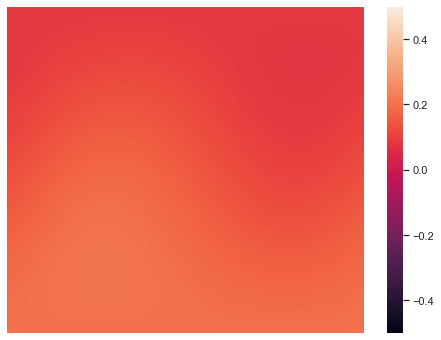

iteration 50: loss = 97.10159301757812
iteration 100: loss = 91.70828247070312
iteration 150: loss = 82.935302734375
iteration 200: loss = 85.44441986083984
iteration 250: loss = 90.16429901123047
iteration 300: loss = 80.05754089355469
iteration 350: loss = 75.11202239990234
iteration 400: loss = 67.35933685302734
iteration 450: loss = 80.64694213867188
iteration 500: loss = 73.17830657958984


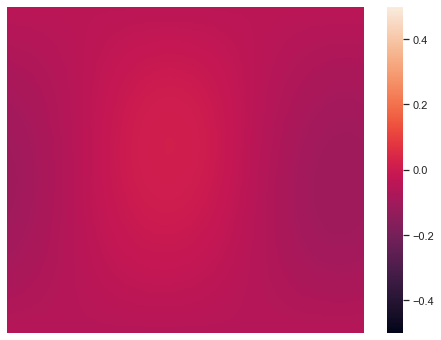

iteration 550: loss = 83.79805755615234
iteration 600: loss = 99.03775787353516
iteration 650: loss = 77.35993194580078
iteration 700: loss = 81.16410064697266
iteration 750: loss = 80.84498596191406
iteration 800: loss = 59.11109161376953
iteration 850: loss = 96.6806411743164
iteration 900: loss = 83.0767593383789
iteration 950: loss = 88.62968444824219
iteration 1000: loss = 71.61138916015625


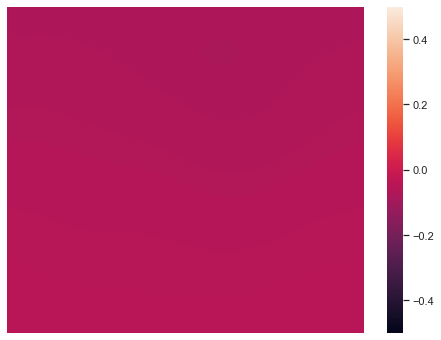

iteration 1050: loss = 79.05091857910156
iteration 1100: loss = 72.21366119384766
iteration 1150: loss = 56.97797775268555
iteration 1200: loss = 93.9467544555664
iteration 1250: loss = 80.46603393554688
iteration 1300: loss = 82.49507904052734
iteration 1350: loss = 81.23433685302734
iteration 1400: loss = 76.18004608154297
iteration 1450: loss = 79.8685073852539
iteration 1500: loss = 91.78988647460938


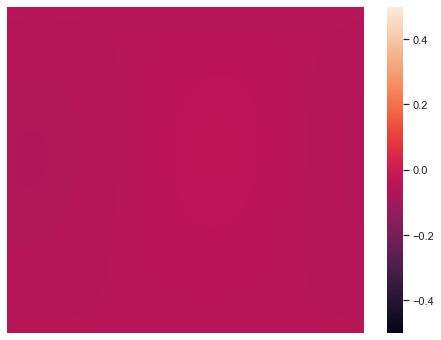

iteration 1550: loss = 85.08248901367188
iteration 1600: loss = 96.3486557006836
iteration 1650: loss = 94.1153564453125
iteration 1700: loss = 85.97022247314453
iteration 1750: loss = 70.58360290527344
iteration 1800: loss = 92.01490783691406
iteration 1850: loss = 67.03400421142578
iteration 1900: loss = 73.61786651611328
iteration 1950: loss = 71.21918487548828
iteration 2000: loss = 93.8822250366211


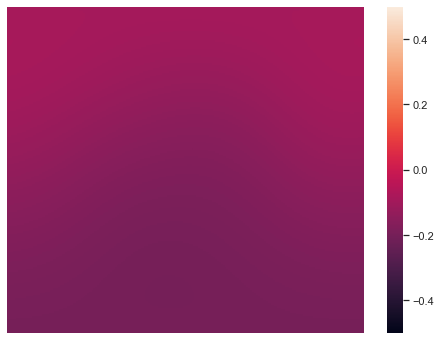

iteration 2050: loss = 86.92626190185547
iteration 2100: loss = 71.75798034667969
iteration 2150: loss = 72.49593353271484
iteration 2200: loss = 92.10920715332031
iteration 2250: loss = 98.00946044921875
iteration 2300: loss = 79.3040771484375
iteration 2350: loss = 68.10762786865234
iteration 2400: loss = 78.67090606689453
iteration 2450: loss = 78.1005859375
iteration 2500: loss = 82.46627807617188


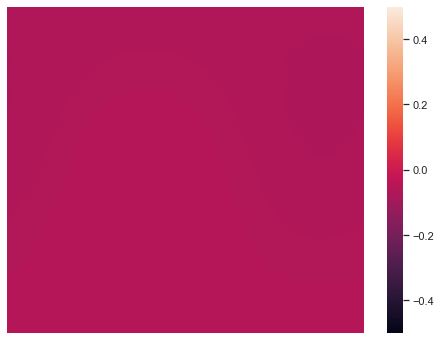

iteration 2550: loss = 76.8744888305664
iteration 2600: loss = 71.66033172607422
iteration 2650: loss = 106.84877014160156
iteration 2700: loss = 87.43045043945312
iteration 2750: loss = 95.39739990234375
iteration 2800: loss = 92.96184539794922
iteration 2850: loss = 90.05154418945312
iteration 2900: loss = 72.59647369384766
iteration 2950: loss = 67.32362365722656
iteration 3000: loss = 78.83583068847656


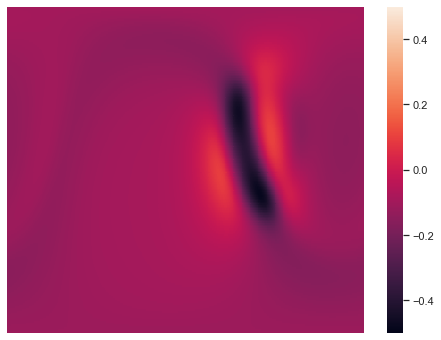

iteration 3050: loss = 73.8046875
iteration 3100: loss = 54.34491729736328
iteration 3150: loss = 46.29951477050781
iteration 3200: loss = 29.902753829956055
iteration 3250: loss = 28.046415328979492
iteration 3300: loss = 26.962783813476562
iteration 3350: loss = 23.996362686157227
iteration 3400: loss = 13.389826774597168
iteration 3450: loss = 11.364578247070312
iteration 3500: loss = 7.983092784881592


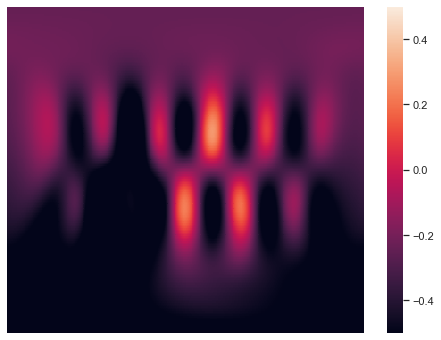

iteration 3550: loss = 2.1520473957061768
iteration 3600: loss = 1.6496305465698242
iteration 3650: loss = 0.8830368518829346
iteration 3700: loss = 1.1541101932525635
iteration 3750: loss = 1.2323743104934692
iteration 3800: loss = 0.7533594965934753
iteration 3850: loss = 0.6869714856147766
iteration 3900: loss = 0.7928922176361084
iteration 3950: loss = 0.6936728358268738
iteration 4000: loss = 0.8401821851730347


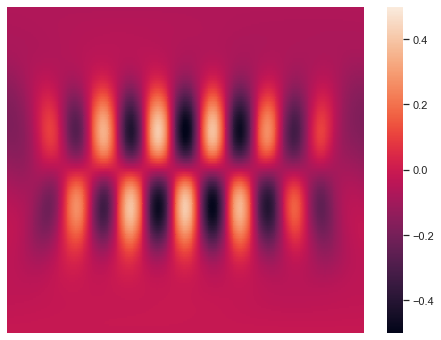

iteration 4050: loss = 0.4690324664115906
iteration 4100: loss = 0.5025297999382019
iteration 4150: loss = 0.3184243142604828
iteration 4200: loss = 0.40319815278053284
iteration 4250: loss = 0.30599328875541687
iteration 4300: loss = 0.37641459703445435
iteration 4350: loss = 0.2953130304813385
iteration 4400: loss = 0.3129253089427948
iteration 4450: loss = 0.21385832130908966
iteration 4500: loss = 0.22591722011566162


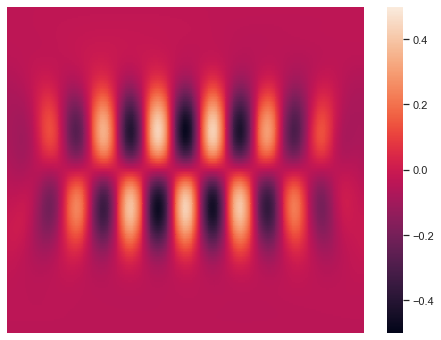

iteration 4550: loss = 0.24570412933826447
iteration 4600: loss = 0.22207577526569366
iteration 4650: loss = 0.14602115750312805
iteration 4700: loss = 0.13717657327651978
iteration 4750: loss = 0.13833358883857727
iteration 4800: loss = 0.09969323873519897
iteration 4850: loss = 0.1215643659234047
iteration 4900: loss = 0.13366657495498657
iteration 4950: loss = 0.1051810160279274


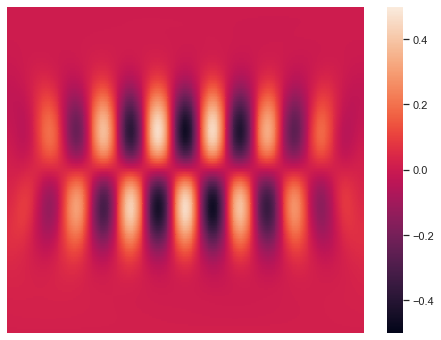

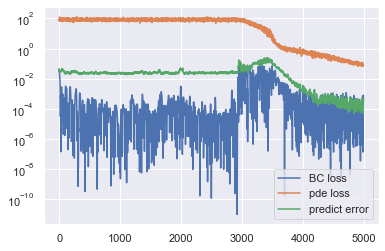

In [1]:
import torch

from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math

torch.manual_seed(0)
maxiter = 5000
problem = Problem_Sphere_Poisson()


def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
            self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, num=200):
            x = torch.randn(num, 3)
            x = x / (torch.norm(x, dim=1).reshape((-1, 1)))
            weidu = torch.acos(x[:, 2:3])
            jingdu = torch.atan(x[:, :1] / x[:, 1:2]) + math.pi / 2
            jingdu[:num // 2, 0] = jingdu[:num // 2, 0] + math.pi
            x = torch.cat([weidu, jingdu], dim=1)
            return x

        def bc_sample(self):
            return torch.tensor([[1., 1.]])

        def init_sample(self):
            pass

        def plot(self, net):
            weidu = torch.linspace(0, math.pi, 200, requires_grad=False)
            jingdu = torch.linspace(0, 2 * math.pi, 400, requires_grad=False)
            weidu, jingdu = torch.meshgrid(weidu, jingdu)
            location = torch.cat([weidu.reshape(-1, 1), jingdu.reshape(-1, 1)], dim=1)
            value = net(location)
            
            value = value.reshape((200, 400))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.show()

        def post_process(self, ax=None):
            if ax is None:
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))
            

        def predict_error(self):
            coor = self.inner_sample(num=1000)
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
                infer_value_inner = net(coor_inner)
                truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)

                bc_samples = self.bc_sample()
                if bc_samples is None:
                    self.bc_loss = torch.tensor(0.)
                else:
                    coor_bc = bc_samples.detach().requires_grad_(True)
                    infer_value_bc = net(coor_bc)
                    truth_bc, predict_bc = problem.bound_condition(coor_bc, infer_value_bc)
                    self.bc_loss = self.bc_loss_f(predict_bc, truth_bc)

                init_samples = self.init_sample()
                if init_samples is None:
                    self.init_loss = torch.tensor(0.)
                else:
                    coor_init = init_samples.detach().requires_grad_(True)
                    infer_value_init = net(coor_init)
                    truth_init, predict_init = problem.bound_condition(coor_init, infer_value_init)
                    self.init_loss = self.bc_loss_f(predict_init, truth_init)
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss + self.bc_loss + self.init_loss
                self.add_loss_history()
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
                
                for i in range(len(self.loss_history)):
                    for j in range(3):
                        self.loss_history[i][j] = self.loss_history[i][j].detach().requires_grad_(False)
                        
                if iter % (maxiter // 100) == 0:
                    print("iteration {}: loss = {}".format(iter, self.total_loss))
                if iter == 100:
                    if ax100: self.plot(self.net, ax100)
                        
                if iter % 500 == 0:
                    self.plot(net)
                
            self.plot(net)
            self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 50, 50, 50, 16, 1]))
model.train()


#### Experiment 2:
* $f(x) = \frac{1}{6}Y_2^1$
* $u(x) = -Y_2^1$, Mercator projection below:
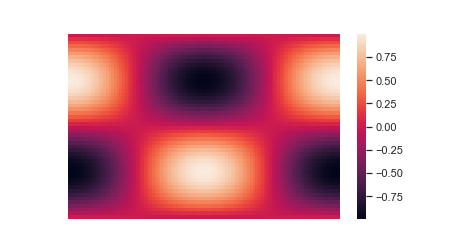 

iteration 0: loss = 2.7155628204345703


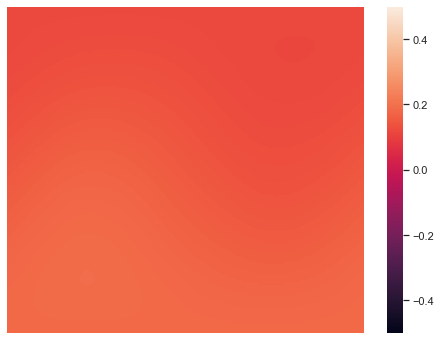

iteration 1: loss = 2.246316432952881
iteration 2: loss = 2.3186702728271484
iteration 3: loss = 2.0629968643188477
iteration 4: loss = 2.391037702560425
iteration 5: loss = 2.447402238845825
iteration 6: loss = 2.069063901901245
iteration 7: loss = 2.441044330596924
iteration 8: loss = 2.455547571182251
iteration 9: loss = 2.3472952842712402
iteration 10: loss = 2.482038736343384


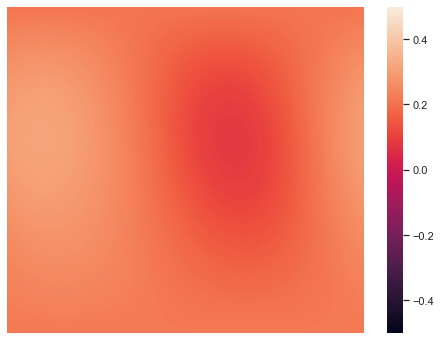

iteration 11: loss = 2.273587942123413
iteration 12: loss = 2.1575849056243896
iteration 13: loss = 1.9512031078338623
iteration 14: loss = 2.2085323333740234
iteration 15: loss = 1.9690403938293457
iteration 16: loss = 1.7747198343276978
iteration 17: loss = 2.332303047180176
iteration 18: loss = 2.0318005084991455
iteration 19: loss = 1.7500131130218506
iteration 20: loss = 1.81288743019104


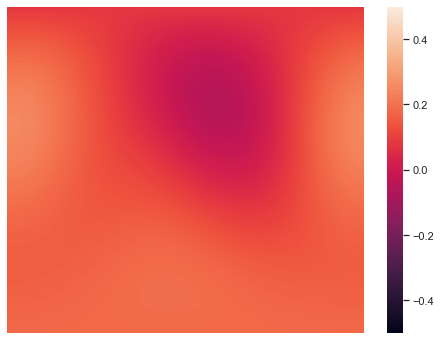

iteration 21: loss = 1.6747047901153564
iteration 22: loss = 1.7218570709228516
iteration 23: loss = 1.5158113241195679
iteration 24: loss = 1.8644565343856812
iteration 25: loss = 1.4051613807678223
iteration 26: loss = 1.4720364809036255
iteration 27: loss = 1.2590771913528442
iteration 28: loss = 1.2014333009719849
iteration 29: loss = 1.1347426176071167
iteration 30: loss = 0.9531010389328003


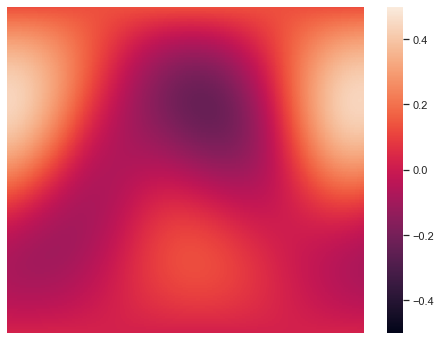

iteration 31: loss = 0.9253519177436829
iteration 32: loss = 0.7774099707603455
iteration 33: loss = 0.6761918067932129
iteration 34: loss = 0.6332269310951233
iteration 35: loss = 0.46376508474349976
iteration 36: loss = 0.395477831363678
iteration 37: loss = 0.3674931526184082
iteration 38: loss = 0.32108673453330994
iteration 39: loss = 0.2936018109321594
iteration 40: loss = 0.3020274043083191


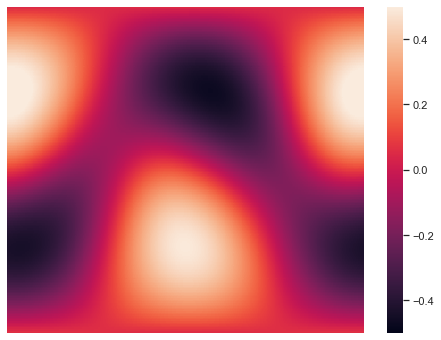

iteration 41: loss = 0.2840801775455475
iteration 42: loss = 0.38717150688171387
iteration 43: loss = 0.3150362968444824
iteration 44: loss = 0.2932727038860321
iteration 45: loss = 0.2665514349937439
iteration 46: loss = 0.1847999095916748
iteration 47: loss = 0.21336449682712555
iteration 48: loss = 0.21784095466136932
iteration 49: loss = 0.13169462978839874
iteration 50: loss = 0.1111588329076767


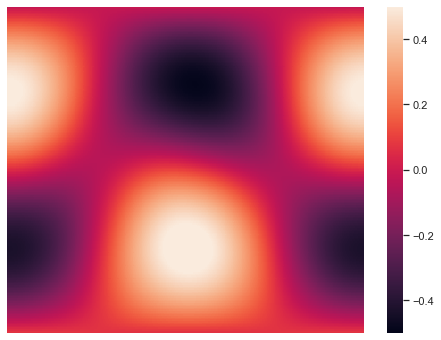

iteration 51: loss = 0.07228389382362366
iteration 52: loss = 0.052958894520998
iteration 53: loss = 0.04543396458029747
iteration 54: loss = 0.03619256615638733
iteration 55: loss = 0.040260400623083115
iteration 56: loss = 0.03520137071609497
iteration 57: loss = 0.03230820596218109
iteration 58: loss = 0.04441385343670845
iteration 59: loss = 0.03195104002952576
iteration 60: loss = 0.027430489659309387


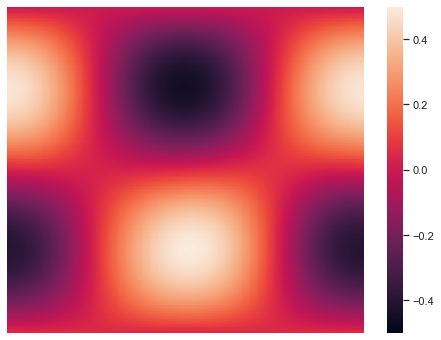

iteration 61: loss = 0.02138609252870083
iteration 62: loss = 0.023120904341340065
iteration 63: loss = 0.02146327868103981
iteration 64: loss = 0.01662309281527996
iteration 65: loss = 0.015139508061110973
iteration 66: loss = 0.013695582747459412
iteration 67: loss = 0.015075288712978363
iteration 68: loss = 0.016247957944869995
iteration 69: loss = 0.017789700999855995
iteration 70: loss = 0.01729421503841877


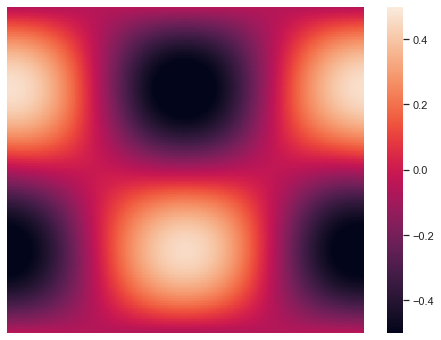

iteration 71: loss = 0.017880257219076157
iteration 72: loss = 0.016553053632378578
iteration 73: loss = 0.017253337427973747
iteration 74: loss = 0.01494226511567831
iteration 75: loss = 0.01506570540368557
iteration 76: loss = 0.012746167369186878
iteration 77: loss = 0.010607169009745121
iteration 78: loss = 0.010019212029874325
iteration 79: loss = 0.007683893665671349
iteration 80: loss = 0.007185385096818209


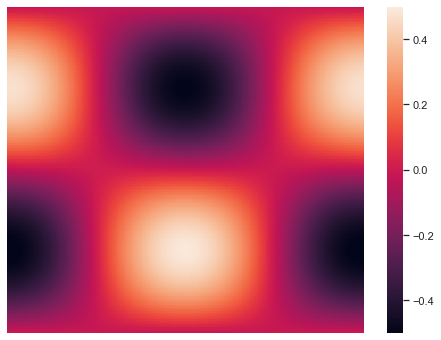

iteration 81: loss = 0.005358229391276836
iteration 82: loss = 0.005453377030789852
iteration 83: loss = 0.005451755598187447
iteration 84: loss = 0.005824457388371229
iteration 85: loss = 0.004712718538939953
iteration 86: loss = 0.0057077244855463505
iteration 87: loss = 0.006655215751379728
iteration 88: loss = 0.005582318641245365
iteration 89: loss = 0.003805736778303981
iteration 90: loss = 0.005072067491710186


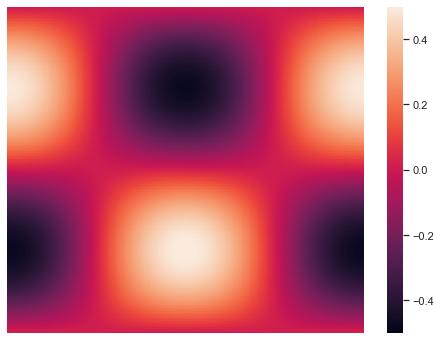

iteration 91: loss = 0.005186650902032852
iteration 92: loss = 0.005035817623138428
iteration 93: loss = 0.0037032191175967455
iteration 94: loss = 0.004056921694427729
iteration 95: loss = 0.004158890340477228
iteration 96: loss = 0.004253576509654522
iteration 97: loss = 0.00399636197835207
iteration 98: loss = 0.0038659842684865
iteration 99: loss = 0.0036932609509676695


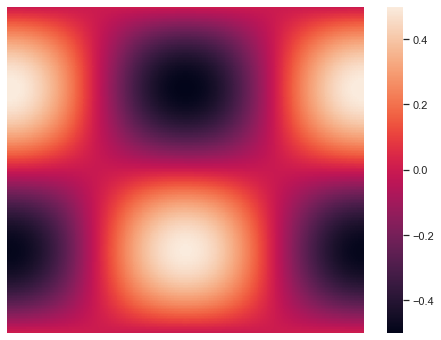

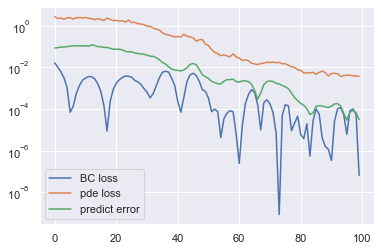

In [1]:
import torch

from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math

torch.manual_seed(0)
maxiter = 100
problem = Problem_Sphere_Poisson()


def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
            self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, num=200):
            x = torch.randn(num, 3)
            x = x / (torch.norm(x, dim=1).reshape((-1, 1)))
            weidu = torch.acos(x[:, 2:3])
            jingdu = torch.atan(x[:, :1] / x[:, 1:2]) + math.pi / 2
            jingdu[:num // 2, 0] = jingdu[:num // 2, 0] + math.pi
            x = torch.cat([weidu, jingdu], dim=1)
            return x

        def bc_sample(self):
            return torch.tensor([[1., 1.]])

        def init_sample(self):
            pass

        def plot(self, net):
            weidu = torch.linspace(0, math.pi, 200, requires_grad=False)
            jingdu = torch.linspace(0, 2 * math.pi, 400, requires_grad=False)
            weidu, jingdu = torch.meshgrid(weidu, jingdu)
            location = torch.cat([weidu.reshape(-1, 1), jingdu.reshape(-1, 1)], dim=1)
            value = net(location)
            
            value = value.reshape((200, 400))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.show()

        def post_process(self, ax=None):
            if ax is None:
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))
            

        def predict_error(self):
            coor = self.inner_sample(num=1000)
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
                infer_value_inner = net(coor_inner)
                truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)

                bc_samples = self.bc_sample()
                if bc_samples is None:
                    self.bc_loss = torch.tensor(0.)
                else:
                    coor_bc = bc_samples.detach().requires_grad_(True)
                    infer_value_bc = net(coor_bc)
                    truth_bc, predict_bc = problem.bound_condition(coor_bc, infer_value_bc)
                    self.bc_loss = self.bc_loss_f(predict_bc, truth_bc)

                init_samples = self.init_sample()
                if init_samples is None:
                    self.init_loss = torch.tensor(0.)
                else:
                    coor_init = init_samples.detach().requires_grad_(True)
                    infer_value_init = net(coor_init)
                    truth_init, predict_init = problem.bound_condition(coor_init, infer_value_init)
                    self.init_loss = self.bc_loss_f(predict_init, truth_init)
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss + self.bc_loss + self.init_loss
                self.add_loss_history()
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
                
                for i in range(len(self.loss_history)):
                    for j in range(3):
                        self.loss_history[i][j] = self.loss_history[i][j].detach().requires_grad_(False)
                        
                if iter % (maxiter // 100) == 0:
                    print("iteration {}: loss = {}".format(iter, self.total_loss))
                if iter == 100:
                    if ax100: self.plot(self.net, ax100)
                        
                if iter % 10 == 0:
                    self.plot(net)
                
            self.plot(net)
            self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 50, 50, 50, 16, 1]))
model.train()


iteration 0: loss = 46.81504821777344


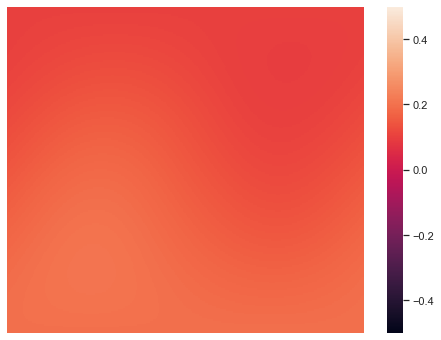

iteration 50: loss = 51.17633819580078
iteration 100: loss = 48.01433563232422
iteration 150: loss = 47.89344024658203
iteration 200: loss = 51.36052322387695
iteration 250: loss = 52.69263458251953
iteration 300: loss = 44.7072868347168
iteration 350: loss = 45.666709899902344
iteration 400: loss = 51.460693359375
iteration 450: loss = 48.46139907836914
iteration 500: loss = 54.92481231689453


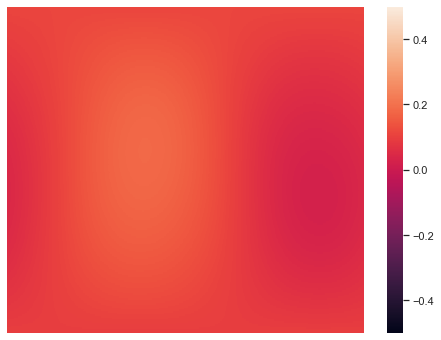

iteration 550: loss = 43.266502380371094
iteration 600: loss = 52.496063232421875
iteration 650: loss = 45.21511459350586
iteration 700: loss = 50.40484619140625
iteration 750: loss = 48.76713562011719
iteration 800: loss = 45.14072799682617
iteration 850: loss = 47.52313232421875
iteration 900: loss = 50.821144104003906
iteration 950: loss = 51.5704345703125
iteration 1000: loss = 45.51590347290039


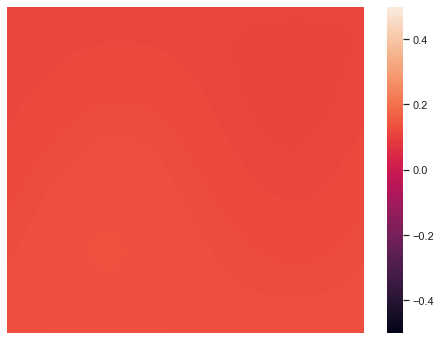

iteration 1050: loss = 48.70817565917969
iteration 1100: loss = 38.815032958984375
iteration 1150: loss = 36.08024978637695
iteration 1200: loss = 44.45012283325195
iteration 1250: loss = 49.75038528442383
iteration 1300: loss = 44.6707763671875
iteration 1350: loss = 51.89335250854492
iteration 1400: loss = 52.000640869140625
iteration 1450: loss = 55.592159271240234
iteration 1500: loss = 48.40205001831055


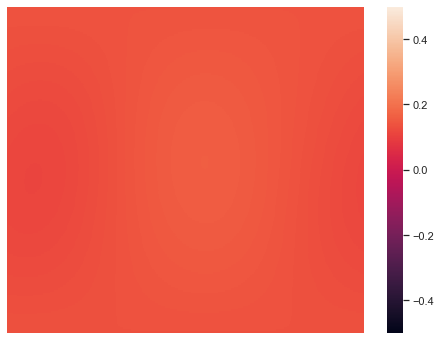

iteration 1550: loss = 51.600547790527344
iteration 1600: loss = 51.345829010009766
iteration 1650: loss = 53.748512268066406
iteration 1700: loss = 52.86252212524414
iteration 1750: loss = 43.01655578613281
iteration 1800: loss = 51.3936882019043
iteration 1850: loss = 44.29527282714844
iteration 1900: loss = 45.41914367675781
iteration 1950: loss = 49.083152770996094
iteration 2000: loss = 45.003273010253906


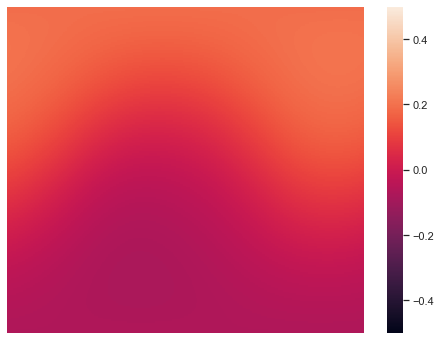

iteration 2050: loss = 49.552616119384766
iteration 2100: loss = 55.28067398071289
iteration 2150: loss = 48.52257537841797
iteration 2200: loss = 52.69751739501953
iteration 2250: loss = 57.80084991455078
iteration 2300: loss = 45.372108459472656
iteration 2350: loss = 42.19440460205078
iteration 2400: loss = 51.83980941772461
iteration 2450: loss = 46.74897766113281
iteration 2500: loss = 46.35271072387695


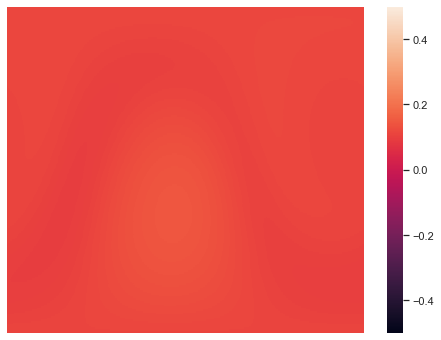

iteration 2550: loss = 43.01025390625
iteration 2600: loss = 38.0062141418457
iteration 2650: loss = 39.50397872924805
iteration 2700: loss = 29.657957077026367
iteration 2750: loss = 21.794321060180664
iteration 2800: loss = 12.936546325683594
iteration 2850: loss = 10.95689582824707
iteration 2900: loss = 10.007046699523926
iteration 2950: loss = 9.586806297302246
iteration 3000: loss = 11.021227836608887


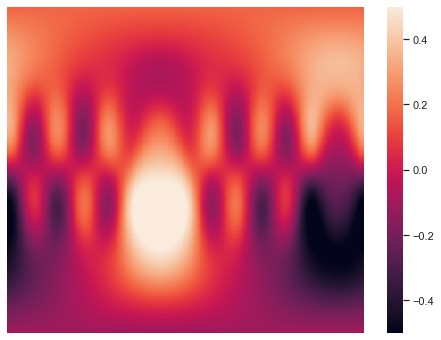

iteration 3050: loss = 8.705280303955078
iteration 3100: loss = 7.611583232879639
iteration 3150: loss = 6.632194995880127
iteration 3200: loss = 6.295341968536377
iteration 3250: loss = 4.237436294555664
iteration 3300: loss = 4.115229606628418
iteration 3350: loss = 3.5874571800231934
iteration 3400: loss = 3.185004472732544
iteration 3450: loss = 3.8548216819763184
iteration 3500: loss = 2.070213794708252


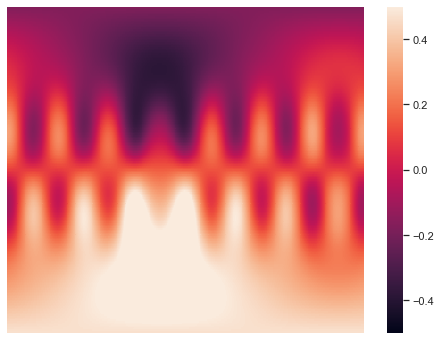

iteration 3550: loss = 1.99738347530365
iteration 3600: loss = 2.304070472717285
iteration 3650: loss = 2.5249598026275635
iteration 3700: loss = 2.281709909439087
iteration 3750: loss = 0.9236956834793091
iteration 3800: loss = 1.8422436714172363
iteration 3850: loss = 2.363906145095825
iteration 3900: loss = 2.14018177986145
iteration 3950: loss = 1.0441831350326538
iteration 4000: loss = 1.0282344818115234


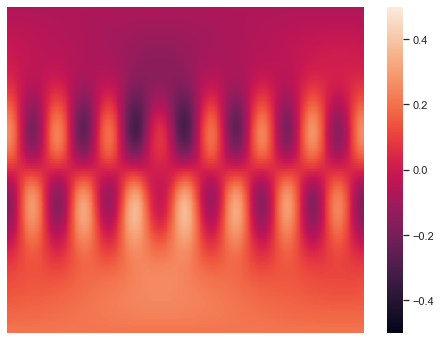

iteration 4050: loss = 0.8088670372962952
iteration 4100: loss = 0.8019388318061829
iteration 4150: loss = 0.4050302803516388
iteration 4200: loss = 0.4659566283226013
iteration 4250: loss = 0.563326358795166
iteration 4300: loss = 0.4318400025367737
iteration 4350: loss = 0.391065776348114
iteration 4400: loss = 0.2174321413040161
iteration 4450: loss = 0.24366416037082672
iteration 4500: loss = 0.16917787492275238


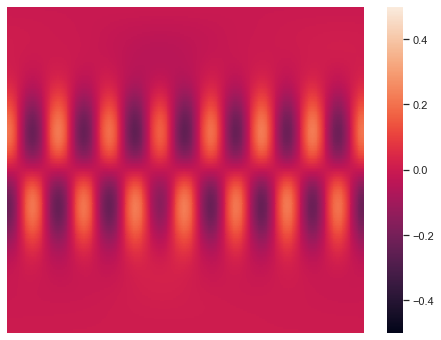

iteration 4550: loss = 0.18455742299556732
iteration 4600: loss = 0.132731094956398
iteration 4650: loss = 0.21674275398254395
iteration 4700: loss = 0.17291569709777832
iteration 4750: loss = 0.12924014031887054
iteration 4800: loss = 0.12823979556560516
iteration 4850: loss = 0.10566128045320511
iteration 4900: loss = 0.11583315581083298
iteration 4950: loss = 0.13465724885463715


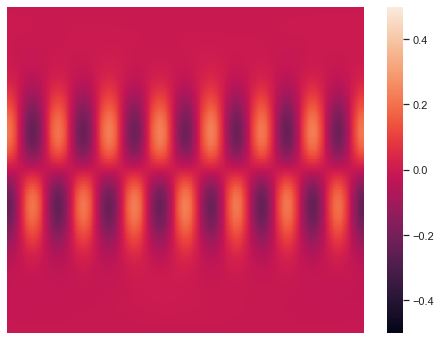

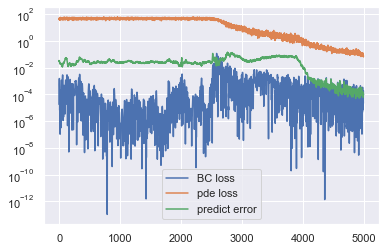

In [1]:
import torch

from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math

torch.manual_seed(0)
maxiter = 5000
problem = Problem_Sphere_Poisson()


def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
            self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, num=200):
            x = torch.randn(num, 3)
            x = x / (torch.norm(x, dim=1).reshape((-1, 1)))
            weidu = torch.acos(x[:, 2:3])
            jingdu = torch.atan(x[:, :1] / x[:, 1:2]) + math.pi / 2
            jingdu[:num // 2, 0] = jingdu[:num // 2, 0] + math.pi
            x = torch.cat([weidu, jingdu], dim=1)
            return x

        def bc_sample(self):
            return torch.tensor([[1., 1.]])

        def init_sample(self):
            pass

        def plot(self, net):
            weidu = torch.linspace(0, math.pi, 200, requires_grad=False)
            jingdu = torch.linspace(0, 2 * math.pi, 400, requires_grad=False)
            weidu, jingdu = torch.meshgrid(weidu, jingdu)
            location = torch.cat([weidu.reshape(-1, 1), jingdu.reshape(-1, 1)], dim=1)
            value = net(location)
            
            value = value.reshape((200, 400))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.show()

        def post_process(self, ax=None):
            if ax is None:
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))
            

        def predict_error(self):
            coor = self.inner_sample(num=1000)
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
                infer_value_inner = net(coor_inner)
                truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)

                bc_samples = self.bc_sample()
                if bc_samples is None:
                    self.bc_loss = torch.tensor(0.)
                else:
                    coor_bc = bc_samples.detach().requires_grad_(True)
                    infer_value_bc = net(coor_bc)
                    truth_bc, predict_bc = problem.bound_condition(coor_bc, infer_value_bc)
                    self.bc_loss = self.bc_loss_f(predict_bc, truth_bc)

                init_samples = self.init_sample()
                if init_samples is None:
                    self.init_loss = torch.tensor(0.)
                else:
                    coor_init = init_samples.detach().requires_grad_(True)
                    infer_value_init = net(coor_init)
                    truth_init, predict_init = problem.bound_condition(coor_init, infer_value_init)
                    self.init_loss = self.bc_loss_f(predict_init, truth_init)
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss + self.bc_loss + self.init_loss
                self.add_loss_history()
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
                
                for i in range(len(self.loss_history)):
                    for j in range(3):
                        self.loss_history[i][j] = self.loss_history[i][j].detach().requires_grad_(False)
                        
                if iter % (maxiter // 100) == 0:
                    print("iteration {}: loss = {}".format(iter, self.total_loss))
                if iter == 100:
                    if ax100: self.plot(self.net, ax100)
                        
                if iter % 500 == 0:
                    self.plot(net)
                
            self.plot(net)
            self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 50, 50, 50, 16, 1]))
model.train()


#### preliminary attempt for using H^-1 loss:
using the pde in the paper

C:\Users\ifisa\Downloads\PDPINN\PDPINN\Model.py:25: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:240.)
  P = P.to(torch.float32)


iteration 0: loss = tensor([[2.2316]], grad_fn=<AddBackward0>)


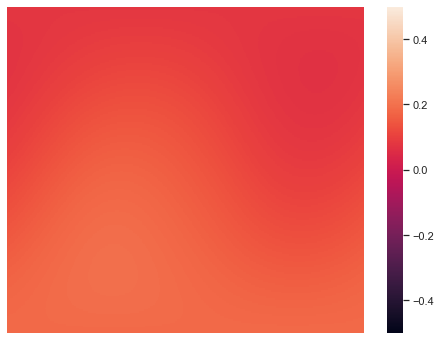

iteration 50: loss = tensor([[0.2779]], grad_fn=<AddBackward0>)
iteration 100: loss = tensor([[0.5928]], grad_fn=<AddBackward0>)
iteration 150: loss = tensor([[1.0943]], grad_fn=<AddBackward0>)
iteration 200: loss = tensor([[0.4494]], grad_fn=<AddBackward0>)
iteration 250: loss = tensor([[0.3958]], grad_fn=<AddBackward0>)
iteration 300: loss = tensor([[1.1455]], grad_fn=<AddBackward0>)
iteration 350: loss = tensor([[0.1753]], grad_fn=<AddBackward0>)
iteration 400: loss = tensor([[1.2517]], grad_fn=<AddBackward0>)
iteration 450: loss = tensor([[0.5910]], grad_fn=<AddBackward0>)
iteration 500: loss = tensor([[0.4143]], grad_fn=<AddBackward0>)


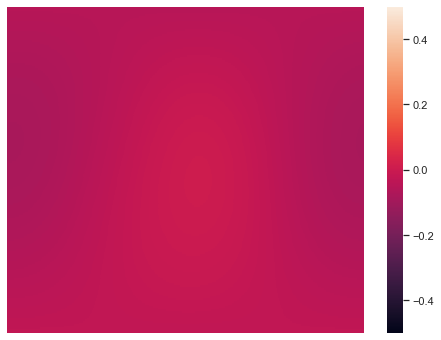

iteration 550: loss = tensor([[0.7396]], grad_fn=<AddBackward0>)
iteration 600: loss = tensor([[3.1415]], grad_fn=<AddBackward0>)
iteration 650: loss = tensor([[0.9271]], grad_fn=<AddBackward0>)
iteration 700: loss = tensor([[0.2725]], grad_fn=<AddBackward0>)
iteration 750: loss = tensor([[1.3225]], grad_fn=<AddBackward0>)
iteration 800: loss = tensor([[0.9022]], grad_fn=<AddBackward0>)
iteration 850: loss = tensor([[0.4968]], grad_fn=<AddBackward0>)
iteration 900: loss = tensor([[1.3672]], grad_fn=<AddBackward0>)
iteration 950: loss = tensor([[0.3933]], grad_fn=<AddBackward0>)
iteration 1000: loss = tensor([[1.2861]], grad_fn=<AddBackward0>)


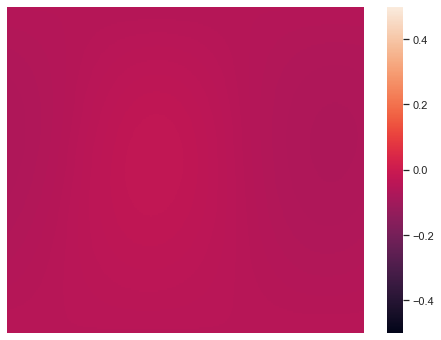

iteration 1050: loss = tensor([[0.3030]], grad_fn=<AddBackward0>)
iteration 1100: loss = tensor([[0.6534]], grad_fn=<AddBackward0>)
iteration 1150: loss = tensor([[0.2402]], grad_fn=<AddBackward0>)
iteration 1200: loss = tensor([[0.2587]], grad_fn=<AddBackward0>)
iteration 1250: loss = tensor([[1.8957]], grad_fn=<AddBackward0>)
iteration 1300: loss = tensor([[0.3668]], grad_fn=<AddBackward0>)
iteration 1350: loss = tensor([[1.0599]], grad_fn=<AddBackward0>)
iteration 1400: loss = tensor([[3.3867]], grad_fn=<AddBackward0>)
iteration 1450: loss = tensor([[0.5601]], grad_fn=<AddBackward0>)
iteration 1500: loss = tensor([[0.7519]], grad_fn=<AddBackward0>)


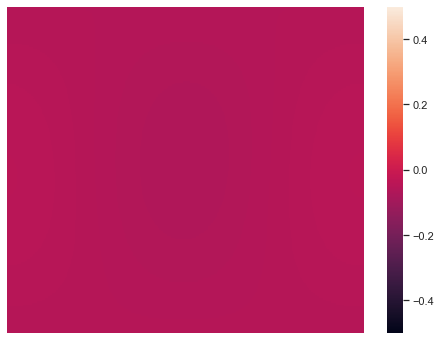

iteration 1550: loss = tensor([[0.9766]], grad_fn=<AddBackward0>)
iteration 1600: loss = tensor([[0.7906]], grad_fn=<AddBackward0>)
iteration 1650: loss = tensor([[0.9123]], grad_fn=<AddBackward0>)
iteration 1700: loss = tensor([[0.6300]], grad_fn=<AddBackward0>)
iteration 1750: loss = tensor([[0.3262]], grad_fn=<AddBackward0>)
iteration 1800: loss = tensor([[3.6148]], grad_fn=<AddBackward0>)
iteration 1850: loss = tensor([[0.2412]], grad_fn=<AddBackward0>)
iteration 1900: loss = tensor([[0.3642]], grad_fn=<AddBackward0>)
iteration 1950: loss = tensor([[0.4473]], grad_fn=<AddBackward0>)
iteration 2000: loss = tensor([[1.0990]], grad_fn=<AddBackward0>)


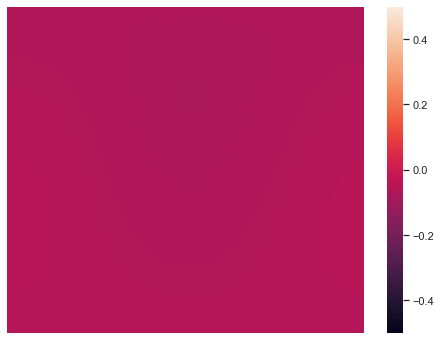

iteration 2050: loss = tensor([[0.5331]], grad_fn=<AddBackward0>)
iteration 2100: loss = tensor([[1.2233]], grad_fn=<AddBackward0>)
iteration 2150: loss = tensor([[0.7408]], grad_fn=<AddBackward0>)
iteration 2200: loss = tensor([[0.5080]], grad_fn=<AddBackward0>)
iteration 2250: loss = tensor([[0.5367]], grad_fn=<AddBackward0>)
iteration 2300: loss = tensor([[0.4263]], grad_fn=<AddBackward0>)
iteration 2350: loss = tensor([[0.9720]], grad_fn=<AddBackward0>)
iteration 2400: loss = tensor([[0.6109]], grad_fn=<AddBackward0>)
iteration 2450: loss = tensor([[1.2551]], grad_fn=<AddBackward0>)
iteration 2500: loss = tensor([[0.3331]], grad_fn=<AddBackward0>)


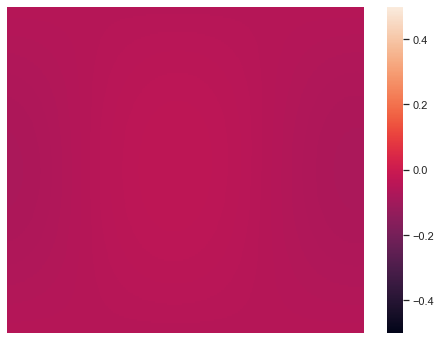

iteration 2550: loss = tensor([[0.5222]], grad_fn=<AddBackward0>)
iteration 2600: loss = tensor([[0.2698]], grad_fn=<AddBackward0>)
iteration 2650: loss = tensor([[1.9348]], grad_fn=<AddBackward0>)
iteration 2700: loss = tensor([[0.7139]], grad_fn=<AddBackward0>)
iteration 2750: loss = tensor([[0.7669]], grad_fn=<AddBackward0>)
iteration 2800: loss = tensor([[0.8210]], grad_fn=<AddBackward0>)
iteration 2850: loss = tensor([[0.6427]], grad_fn=<AddBackward0>)
iteration 2900: loss = tensor([[0.4770]], grad_fn=<AddBackward0>)
iteration 2950: loss = tensor([[0.3212]], grad_fn=<AddBackward0>)
iteration 3000: loss = tensor([[1.1044]], grad_fn=<AddBackward0>)


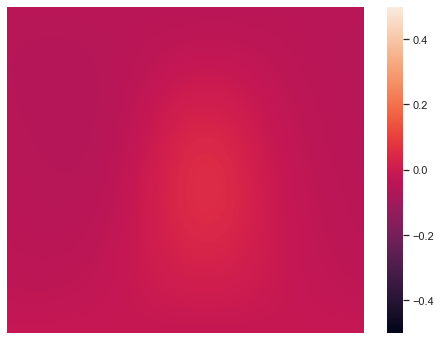

iteration 3050: loss = tensor([[0.4742]], grad_fn=<AddBackward0>)
iteration 3100: loss = tensor([[0.7596]], grad_fn=<AddBackward0>)
iteration 3150: loss = tensor([[0.3294]], grad_fn=<AddBackward0>)
iteration 3200: loss = tensor([[0.7371]], grad_fn=<AddBackward0>)
iteration 3250: loss = tensor([[2.7264]], grad_fn=<AddBackward0>)
iteration 3300: loss = tensor([[1.3660]], grad_fn=<AddBackward0>)
iteration 3350: loss = tensor([[0.4305]], grad_fn=<AddBackward0>)
iteration 3400: loss = tensor([[0.6160]], grad_fn=<AddBackward0>)
iteration 3450: loss = tensor([[0.9463]], grad_fn=<AddBackward0>)
iteration 3500: loss = tensor([[0.7027]], grad_fn=<AddBackward0>)


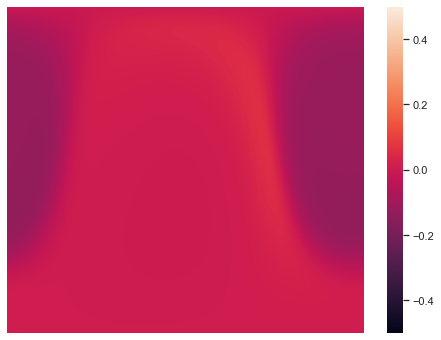

iteration 3550: loss = tensor([[0.3875]], grad_fn=<AddBackward0>)
iteration 3600: loss = tensor([[0.4583]], grad_fn=<AddBackward0>)
iteration 3650: loss = tensor([[0.7064]], grad_fn=<AddBackward0>)
iteration 3700: loss = tensor([[1.3082]], grad_fn=<AddBackward0>)
iteration 3750: loss = tensor([[0.4953]], grad_fn=<AddBackward0>)
iteration 3800: loss = tensor([[2.2223]], grad_fn=<AddBackward0>)
iteration 3850: loss = tensor([[1.6461]], grad_fn=<AddBackward0>)
iteration 3900: loss = tensor([[0.5829]], grad_fn=<AddBackward0>)
iteration 3950: loss = tensor([[0.9742]], grad_fn=<AddBackward0>)
iteration 4000: loss = tensor([[0.3186]], grad_fn=<AddBackward0>)


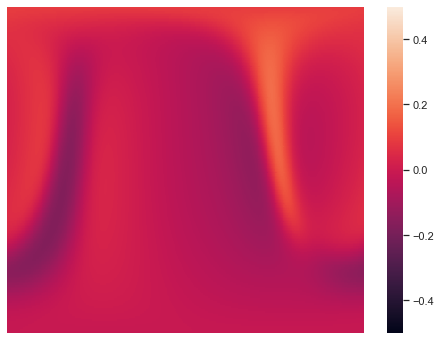

iteration 4050: loss = tensor([[0.5631]], grad_fn=<AddBackward0>)
iteration 4100: loss = tensor([[0.5823]], grad_fn=<AddBackward0>)
iteration 4150: loss = tensor([[0.8973]], grad_fn=<AddBackward0>)
iteration 4200: loss = tensor([[0.5750]], grad_fn=<AddBackward0>)
iteration 4250: loss = tensor([[0.7616]], grad_fn=<AddBackward0>)
iteration 4300: loss = tensor([[0.2827]], grad_fn=<AddBackward0>)
iteration 4350: loss = tensor([[0.3486]], grad_fn=<AddBackward0>)
iteration 4400: loss = tensor([[0.4588]], grad_fn=<AddBackward0>)
iteration 4450: loss = tensor([[1.2527]], grad_fn=<AddBackward0>)
iteration 4500: loss = tensor([[0.2652]], grad_fn=<AddBackward0>)


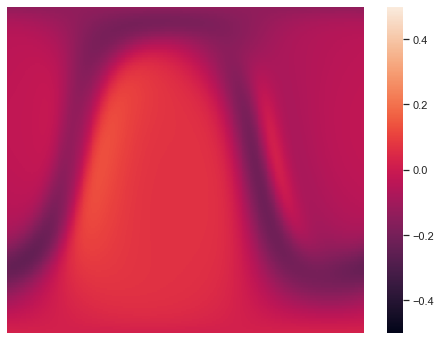

iteration 4550: loss = tensor([[0.4772]], grad_fn=<AddBackward0>)
iteration 4600: loss = tensor([[0.7650]], grad_fn=<AddBackward0>)
iteration 4650: loss = tensor([[0.2486]], grad_fn=<AddBackward0>)
iteration 4700: loss = tensor([[0.6698]], grad_fn=<AddBackward0>)
iteration 4750: loss = tensor([[0.3860]], grad_fn=<AddBackward0>)
iteration 4800: loss = tensor([[0.9416]], grad_fn=<AddBackward0>)
iteration 4850: loss = tensor([[0.4080]], grad_fn=<AddBackward0>)
iteration 4900: loss = tensor([[3.0303]], grad_fn=<AddBackward0>)
iteration 4950: loss = tensor([[0.5078]], grad_fn=<AddBackward0>)


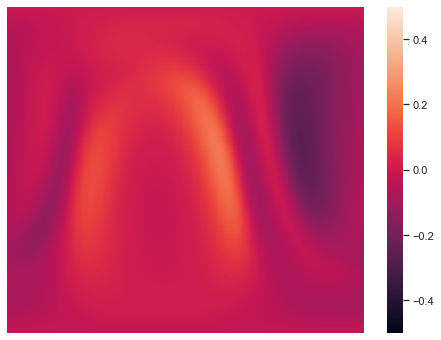

C:\Users\ifisa\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Users\ifisa\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


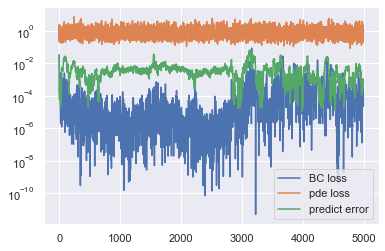

In [1]:
import torch

from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math

torch.manual_seed(0)
maxiter = 5000
problem = Problem_Sphere_Poisson()


def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
            self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, num=200):
            x = torch.randn(num, 3)
            x = x / (torch.norm(x, dim=1).reshape((-1, 1)))
            weidu = torch.acos(x[:, 2:3])
            jingdu = torch.atan(x[:, :1] / x[:, 1:2]) + math.pi / 2
            jingdu[:num // 2, 0] = jingdu[:num // 2, 0] + math.pi
            x = torch.cat([weidu, jingdu], dim=1)
            return x

        def bc_sample(self):
            return torch.tensor([[1., 1.]])

        def init_sample(self):
            pass

        def plot(self, net):
            weidu = torch.linspace(0, math.pi, 200, requires_grad=False)
            jingdu = torch.linspace(0, 2 * math.pi, 400, requires_grad=False)
            weidu, jingdu = torch.meshgrid(weidu, jingdu)
            location = torch.cat([weidu.reshape(-1, 1), jingdu.reshape(-1, 1)], dim=1)
            value = net(location)
            
            value = value.reshape((200, 400))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.show()

        def post_process(self, ax=None):
            if ax is None:
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))
            

        def predict_error(self):
            coor = self.inner_sample(num=1000)
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
                infer_value_inner = net(coor_inner)
                truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)

                bc_samples = self.bc_sample()
                if bc_samples is None:
                    self.bc_loss = torch.tensor(0.)
                else:
                    coor_bc = bc_samples.detach().requires_grad_(True)
                    infer_value_bc = net(coor_bc)
                    truth_bc, predict_bc = problem.bound_condition(coor_bc, infer_value_bc)
                    self.bc_loss = self.bc_loss_f(predict_bc, truth_bc)

                init_samples = self.init_sample()
                if init_samples is None:
                    self.init_loss = torch.tensor(0.)
                else:
                    coor_init = init_samples.detach().requires_grad_(True)
                    infer_value_init = net(coor_init)
                    truth_init, predict_init = problem.bound_condition(coor_init, infer_value_init)
                    self.init_loss = self.bc_loss_f(predict_init, truth_init)
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss + self.bc_loss + self.init_loss
                self.add_loss_history()
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
                
                for i in range(len(self.loss_history)):
                    for j in range(3):
                        self.loss_history[i][j] = self.loss_history[i][j].detach().requires_grad_(False)
                        
                if iter % (maxiter // 100) == 0:
                    print("iteration {}: loss = {}".format(iter, self.total_loss))
                if iter == 100:
                    if ax100: self.plot(self.net, ax100)
                        
                if iter % 500 == 0:
                    self.plot(net)
                
            self.plot(net)
            self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 50, 50, 50, 16, 1]))
model.train()


#### preliminary attempt for using H^1 loss:
using the pde in the paper

C:\Users\ifisa\Downloads\PDPINN\PDPINN\Model.py:25: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:240.)
  P = P.to(torch.float32)


iteration 0: loss = tensor([[1133483.2500]], grad_fn=<AddBackward0>)


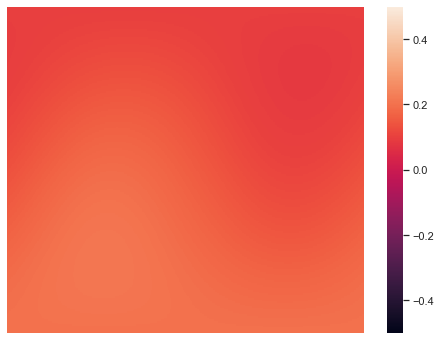

iteration 50: loss = tensor([[1291012.2500]], grad_fn=<AddBackward0>)
iteration 100: loss = tensor([[1249083.3750]], grad_fn=<AddBackward0>)
iteration 150: loss = tensor([[1133726.3750]], grad_fn=<AddBackward0>)
iteration 200: loss = tensor([[1102774.5000]], grad_fn=<AddBackward0>)
iteration 250: loss = tensor([[1185461.6250]], grad_fn=<AddBackward0>)
iteration 300: loss = tensor([[1061544.7500]], grad_fn=<AddBackward0>)
iteration 350: loss = tensor([[971083.6875]], grad_fn=<AddBackward0>)
iteration 400: loss = tensor([[884654.6250]], grad_fn=<AddBackward0>)
iteration 450: loss = tensor([[1056888.2500]], grad_fn=<AddBackward0>)
iteration 500: loss = tensor([[985713.3125]], grad_fn=<AddBackward0>)


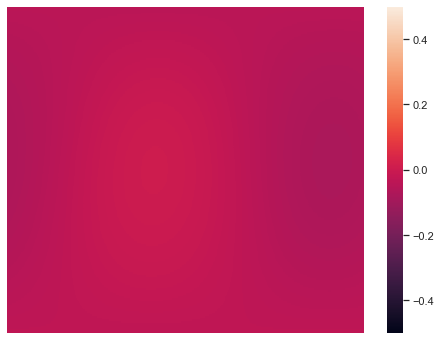

iteration 550: loss = tensor([[1100581.8750]], grad_fn=<AddBackward0>)
iteration 600: loss = tensor([[1265450.8750]], grad_fn=<AddBackward0>)
iteration 650: loss = tensor([[1016934.6875]], grad_fn=<AddBackward0>)
iteration 700: loss = tensor([[1052085.5000]], grad_fn=<AddBackward0>)
iteration 750: loss = tensor([[1051421.6250]], grad_fn=<AddBackward0>)
iteration 800: loss = tensor([[758676.0625]], grad_fn=<AddBackward0>)
iteration 850: loss = tensor([[1315344.5000]], grad_fn=<AddBackward0>)
iteration 900: loss = tensor([[1105022.2500]], grad_fn=<AddBackward0>)
iteration 950: loss = tensor([[1246379.2500]], grad_fn=<AddBackward0>)
iteration 1000: loss = tensor([[933919.4375]], grad_fn=<AddBackward0>)


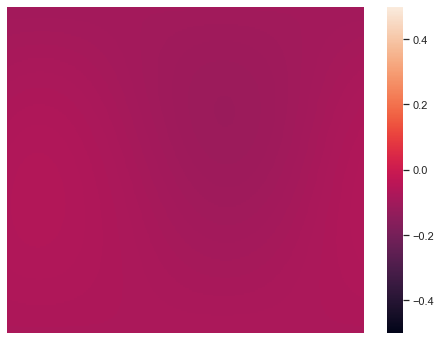

iteration 1050: loss = tensor([[1020507.1250]], grad_fn=<AddBackward0>)
iteration 1100: loss = tensor([[964895.5000]], grad_fn=<AddBackward0>)
iteration 1150: loss = tensor([[784194.0625]], grad_fn=<AddBackward0>)
iteration 1200: loss = tensor([[1225419.6250]], grad_fn=<AddBackward0>)
iteration 1250: loss = tensor([[1086318.1250]], grad_fn=<AddBackward0>)
iteration 1300: loss = tensor([[1101783.8750]], grad_fn=<AddBackward0>)
iteration 1350: loss = tensor([[1071736.1250]], grad_fn=<AddBackward0>)
iteration 1400: loss = tensor([[994099.6875]], grad_fn=<AddBackward0>)
iteration 1450: loss = tensor([[1046059.6875]], grad_fn=<AddBackward0>)
iteration 1500: loss = tensor([[1212993.]], grad_fn=<AddBackward0>)


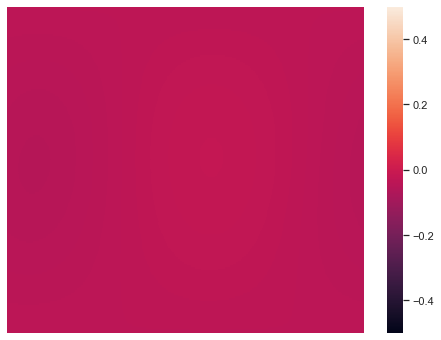

iteration 1550: loss = tensor([[1132824.7500]], grad_fn=<AddBackward0>)
iteration 1600: loss = tensor([[1269229.3750]], grad_fn=<AddBackward0>)
iteration 1650: loss = tensor([[1292001.5000]], grad_fn=<AddBackward0>)
iteration 1700: loss = tensor([[1116559.8750]], grad_fn=<AddBackward0>)
iteration 1750: loss = tensor([[938037.3125]], grad_fn=<AddBackward0>)
iteration 1800: loss = tensor([[1182576.8750]], grad_fn=<AddBackward0>)
iteration 1850: loss = tensor([[901625.8125]], grad_fn=<AddBackward0>)
iteration 1900: loss = tensor([[985927.1875]], grad_fn=<AddBackward0>)
iteration 1950: loss = tensor([[977329.3125]], grad_fn=<AddBackward0>)
iteration 2000: loss = tensor([[1268005.7500]], grad_fn=<AddBackward0>)


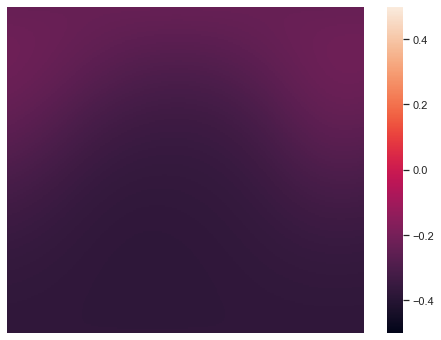

iteration 2050: loss = tensor([[1150738.5000]], grad_fn=<AddBackward0>)
iteration 2100: loss = tensor([[943909.6875]], grad_fn=<AddBackward0>)
iteration 2150: loss = tensor([[961660.6875]], grad_fn=<AddBackward0>)
iteration 2200: loss = tensor([[1230946.2500]], grad_fn=<AddBackward0>)
iteration 2250: loss = tensor([[1300455.8750]], grad_fn=<AddBackward0>)
iteration 2300: loss = tensor([[1059778.5000]], grad_fn=<AddBackward0>)
iteration 2350: loss = tensor([[883392.3750]], grad_fn=<AddBackward0>)
iteration 2400: loss = tensor([[1048182.0625]], grad_fn=<AddBackward0>)
iteration 2450: loss = tensor([[1099394.1250]], grad_fn=<AddBackward0>)
iteration 2500: loss = tensor([[1045567.1250]], grad_fn=<AddBackward0>)


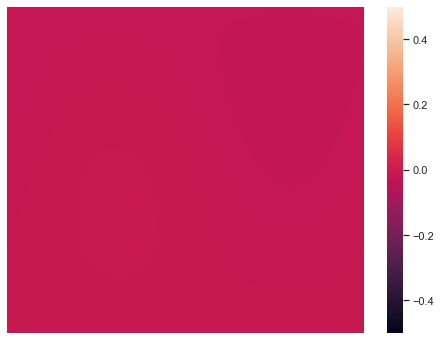

iteration 2550: loss = tensor([[1009211.1250]], grad_fn=<AddBackward0>)
iteration 2600: loss = tensor([[921769.1875]], grad_fn=<AddBackward0>)
iteration 2650: loss = tensor([[1402602.7500]], grad_fn=<AddBackward0>)
iteration 2700: loss = tensor([[1199367.6250]], grad_fn=<AddBackward0>)
iteration 2750: loss = tensor([[1224930.5000]], grad_fn=<AddBackward0>)
iteration 2800: loss = tensor([[1295806.3750]], grad_fn=<AddBackward0>)
iteration 2850: loss = tensor([[1219806.]], grad_fn=<AddBackward0>)
iteration 2900: loss = tensor([[975786.5625]], grad_fn=<AddBackward0>)
iteration 2950: loss = tensor([[983880.1250]], grad_fn=<AddBackward0>)
iteration 3000: loss = tensor([[1146479.2500]], grad_fn=<AddBackward0>)


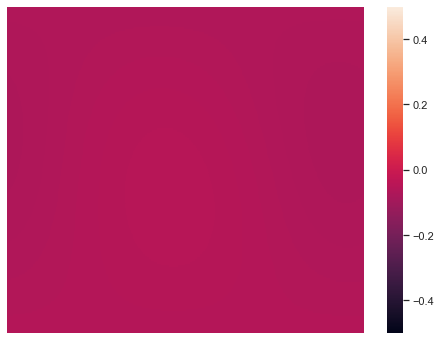

iteration 3050: loss = tensor([[1172942.3750]], grad_fn=<AddBackward0>)
iteration 3100: loss = tensor([[916177.7500]], grad_fn=<AddBackward0>)
iteration 3150: loss = tensor([[1068904.7500]], grad_fn=<AddBackward0>)
iteration 3200: loss = tensor([[1193221.6250]], grad_fn=<AddBackward0>)
iteration 3250: loss = tensor([[1313581.5000]], grad_fn=<AddBackward0>)
iteration 3300: loss = tensor([[1087817.2500]], grad_fn=<AddBackward0>)
iteration 3350: loss = tensor([[1099247.8750]], grad_fn=<AddBackward0>)
iteration 3400: loss = tensor([[893164.2500]], grad_fn=<AddBackward0>)
iteration 3450: loss = tensor([[1125653.6250]], grad_fn=<AddBackward0>)
iteration 3500: loss = tensor([[1143356.5000]], grad_fn=<AddBackward0>)


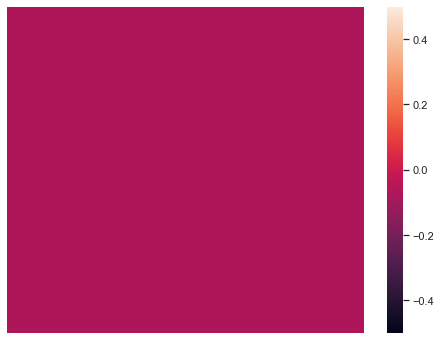

iteration 3550: loss = tensor([[1036178.1875]], grad_fn=<AddBackward0>)
iteration 3600: loss = tensor([[890552.5625]], grad_fn=<AddBackward0>)
iteration 3650: loss = tensor([[925945.]], grad_fn=<AddBackward0>)
iteration 3700: loss = tensor([[1055267.5000]], grad_fn=<AddBackward0>)
iteration 3750: loss = tensor([[978668.6250]], grad_fn=<AddBackward0>)
iteration 3800: loss = tensor([[1131257.1250]], grad_fn=<AddBackward0>)
iteration 3850: loss = tensor([[1120492.2500]], grad_fn=<AddBackward0>)
iteration 3900: loss = tensor([[1128179.2500]], grad_fn=<AddBackward0>)
iteration 3950: loss = tensor([[1232062.2500]], grad_fn=<AddBackward0>)
iteration 4000: loss = tensor([[936412.]], grad_fn=<AddBackward0>)


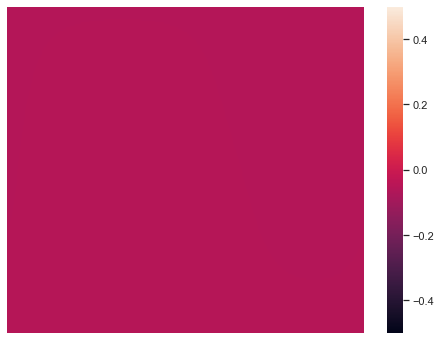

iteration 4050: loss = tensor([[1164476.]], grad_fn=<AddBackward0>)
iteration 4100: loss = tensor([[1123696.8750]], grad_fn=<AddBackward0>)
iteration 4150: loss = tensor([[1126163.2500]], grad_fn=<AddBackward0>)
iteration 4200: loss = tensor([[1188859.3750]], grad_fn=<AddBackward0>)
iteration 4250: loss = tensor([[1042253.]], grad_fn=<AddBackward0>)
iteration 4300: loss = tensor([[1023347.3125]], grad_fn=<AddBackward0>)
iteration 4350: loss = tensor([[1136169.1250]], grad_fn=<AddBackward0>)
iteration 4400: loss = tensor([[1033781.6875]], grad_fn=<AddBackward0>)
iteration 4450: loss = tensor([[1238818.2500]], grad_fn=<AddBackward0>)
iteration 4500: loss = tensor([[837113.7500]], grad_fn=<AddBackward0>)


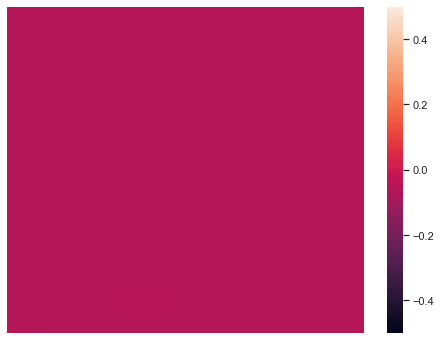

iteration 4550: loss = tensor([[897258.3125]], grad_fn=<AddBackward0>)
iteration 4600: loss = tensor([[1217069.8750]], grad_fn=<AddBackward0>)
iteration 4650: loss = tensor([[991324.7500]], grad_fn=<AddBackward0>)
iteration 4700: loss = tensor([[1169952.2500]], grad_fn=<AddBackward0>)
iteration 4750: loss = tensor([[1046747.5000]], grad_fn=<AddBackward0>)
iteration 4800: loss = tensor([[1022420.3125]], grad_fn=<AddBackward0>)
iteration 4850: loss = tensor([[1158715.6250]], grad_fn=<AddBackward0>)
iteration 4900: loss = tensor([[1216505.7500]], grad_fn=<AddBackward0>)
iteration 4950: loss = tensor([[1214686.5000]], grad_fn=<AddBackward0>)


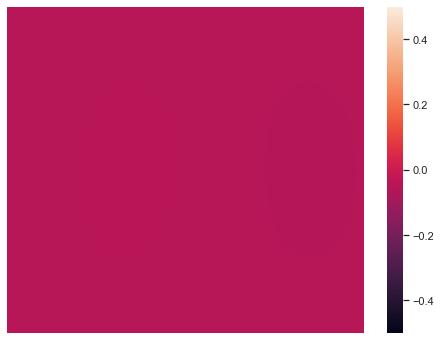

C:\Users\ifisa\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Users\ifisa\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


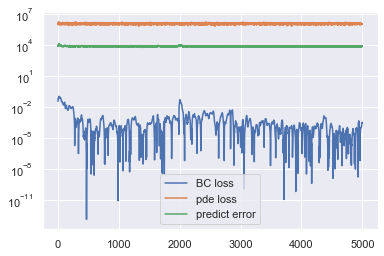

In [1]:
import torch

from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math

torch.manual_seed(0)
maxiter = 5000
problem = Problem_Sphere_Poisson()


def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
            self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, num=200):
            x = torch.randn(num, 3)
            x = x / (torch.norm(x, dim=1).reshape((-1, 1)))
            weidu = torch.acos(x[:, 2:3])
            jingdu = torch.atan(x[:, :1] / x[:, 1:2]) + math.pi / 2
            jingdu[:num // 2, 0] = jingdu[:num // 2, 0] + math.pi
            x = torch.cat([weidu, jingdu], dim=1)
            return x

        def bc_sample(self):
            return torch.tensor([[1., 1.]])

        def init_sample(self):
            pass

        def plot(self, net):
            weidu = torch.linspace(0, math.pi, 200, requires_grad=False)
            jingdu = torch.linspace(0, 2 * math.pi, 400, requires_grad=False)
            weidu, jingdu = torch.meshgrid(weidu, jingdu)
            location = torch.cat([weidu.reshape(-1, 1), jingdu.reshape(-1, 1)], dim=1)
            value = net(location)
            
            value = value.reshape((200, 400))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.show()

        def post_process(self, ax=None):
            if ax is None:
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))
            

        def predict_error(self):
            coor = self.inner_sample(num=1000)
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
                infer_value_inner = net(coor_inner)
                truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)

                bc_samples = self.bc_sample()
                if bc_samples is None:
                    self.bc_loss = torch.tensor(0.)
                else:
                    coor_bc = bc_samples.detach().requires_grad_(True)
                    infer_value_bc = net(coor_bc)
                    truth_bc, predict_bc = problem.bound_condition(coor_bc, infer_value_bc)
                    self.bc_loss = self.bc_loss_f(predict_bc, truth_bc)

                init_samples = self.init_sample()
                if init_samples is None:
                    self.init_loss = torch.tensor(0.)
                else:
                    coor_init = init_samples.detach().requires_grad_(True)
                    infer_value_init = net(coor_init)
                    truth_init, predict_init = problem.bound_condition(coor_init, infer_value_init)
                    self.init_loss = self.bc_loss_f(predict_init, truth_init)
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss + self.bc_loss + self.init_loss
                self.add_loss_history()
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
                
                for i in range(len(self.loss_history)):
                    for j in range(3):
                        self.loss_history[i][j] = self.loss_history[i][j].detach().requires_grad_(False)
                        
                if iter % (maxiter // 100) == 0:
                    print("iteration {}: loss = {}".format(iter, self.total_loss))
                if iter == 100:
                    if ax100: self.plot(self.net, ax100)
                        
                if iter % 500 == 0:
                    self.plot(net)
                
            self.plot(net)
            self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 50, 50, 50, 16, 1]))
model.train()
